In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jinja2

In [2]:
# Read CSV file
df = pd.read_csv('CoffeeShopSales.csv')

# Display the first few rows of the DataFrame df.head()
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,01/01/2023,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,01/01/2023,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,01/01/2023,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,01/01/2023,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,01/01/2023,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [3]:
# Summary from the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB


In [4]:
# Summary from the dataframe with date dtype update and revenue addition

# transaction_date Dtype -> datetime64
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d/%m/%Y')

# transaction_time Dtype -> datetime64
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S')

# Calculate revenue for each transaction
df['revenue'] = df['transaction_qty'] * df['unit_price'].round(0).astype(int)

# Calculate month reference for each transaction
df['month'] = df['transaction_date'].dt.month

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  datetime64[ns]
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
 11  revenue           149116 non-null  int64         
 12  month             149116 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(5), objec

EDA

In [5]:
# Aggregate weekly metrics grouped by purchase week
weekly_summary = df.groupby(df['transaction_date'].dt.to_period('W').rename('revenue_week')).agg(
    total_sales = ('revenue', 'sum'),
    avg_aov = ('revenue', 'mean'),
    total_orders = ('transaction_id', 'count')
)

# Calculate the growth rate for each metric
weekly_summary['sales_growth_rate'] = weekly_summary['total_sales'].pct_change() * 100
weekly_summary['aov_growth_rate'] = weekly_summary['avg_aov'].pct_change() * 100
weekly_summary['total_orders_rate'] = weekly_summary['total_orders'].pct_change() * 100

# Round all floating numbers
weekly_summary['avg_aov'] = weekly_summary['avg_aov'].round(1)
weekly_summary['sales_growth_rate'] = weekly_summary['sales_growth_rate'].round(1)
weekly_summary['aov_growth_rate'] = weekly_summary['aov_growth_rate'].round(1)
weekly_summary['total_orders_rate'] = weekly_summary['total_orders_rate'].round(1)

# Apply color gradient on growth columns
color_summary = weekly_summary.style.format("{:,}")  # Add comma formatting
color_summary = color_summary.background_gradient(
    subset=['sales_growth_rate', 'aov_growth_rate', 'total_orders_rate'],
    cmap= "RdYlGn",
    vmax= 100,
    vmin= -100
)

color_summary


,total_sales,avg_aov,total_orders,sales_growth_rate,aov_growth_rate,total_orders_rate
revenue_week,,,,,,
2022-12-26/2023-01-01,"2,468",4.5,550,nan,nan,nan
2023-01-02/2023-01-08,"16,765",4.4,"3,825",579.3,-2.3,595.5
2023-01-09/2023-01-15,"18,863",4.6,"4,113",12.5,4.6,7.5
2023-01-16/2023-01-22,"19,558",4.9,"4,029",3.7,5.8,-2.0
2023-01-23/2023-01-29,"17,953",4.7,"3,854",-8.2,-4.0,-4.3
2023-01-30/2023-02-05,"16,863",4.5,"3,761",-6.1,-3.7,-2.4
2023-02-06/2023-02-12,"18,040",4.5,"4,005",7.0,0.5,6.5
2023-02-13/2023-02-19,"19,625",4.6,"4,263",8.8,2.2,6.4
2023-02-20/2023-02-26,"19,804",4.8,"4,099",0.9,4.9,-3.8


In [6]:
# Aggregate monthly metrics grouped by store_id and revenue_month
monthly_summary = df.groupby([
    df['store_id'], 
    df['transaction_date'].dt.to_period('M').rename('revenue_month')
]).agg(
    total_sales=('revenue', 'sum'),
    avg_aov=('revenue', 'mean'),
    total_orders=('transaction_id', 'count')
).reset_index()

# Calculate growth rates by store_id
monthly_summary['sales_growth_rate'] = monthly_summary.groupby('store_id')['total_sales'].pct_change() * 100
monthly_summary['aov_growth_rate'] = monthly_summary.groupby('store_id')['avg_aov'].pct_change() * 100
monthly_summary['total_orders_rate'] = monthly_summary.groupby('store_id')['total_orders'].pct_change() * 100

# Round all floating numbers for better readability
monthly_summary['avg_aov'] = monthly_summary['avg_aov'].round(1)
monthly_summary['sales_growth_rate'] = monthly_summary['sales_growth_rate'].round(1)
monthly_summary['aov_growth_rate'] = monthly_summary['aov_growth_rate'].round(1)
monthly_summary['total_orders_rate'] = monthly_summary['total_orders_rate'].round(1)

# Add year and month columns for visualization
monthly_summary['year'] = monthly_summary['revenue_month'].dt.year
monthly_summary['month'] = monthly_summary['revenue_month'].dt.month

monthly_summary.head(10)



,store_id,revenue_month,total_sales,avg_aov,total_orders,sales_growth_rate,aov_growth_rate,total_orders_rate,year,month
0,3,2023-01,26831,4.5,5913,NaN,NaN,NaN,2023,1
1,3,2023-02,24707,4.5,5490,-7.9,-0.8,-7.2,2023,2
2,3,2023-03,32241,4.5,7180,30.5,-0.2,30.8,2023,3
3,3,2023-04,38738,4.5,8556,20.2,0.8,19.2,2023,4
4,3,2023-05,51497,4.5,11475,32.9,-0.9,34.1,2023,5
5,3,2023-06,54081,4.5,11985,5.0,0.5,4.4,2023,6
6,5,2023-01,26183,4.7,5533,NaN,NaN,NaN,2023,1
7,5,2023-02,24934,4.7,5263,-4.8,0.1,-4.9,2023,2
8,5,2023-03,32414,4.8,6782,30.0,0.9,28.9,2023,3
9,5,2023-04,38558,4.7,8150,19.0,-1.0,20.2,2023,4


AttributeError: 'int' object has no attribute 'size'

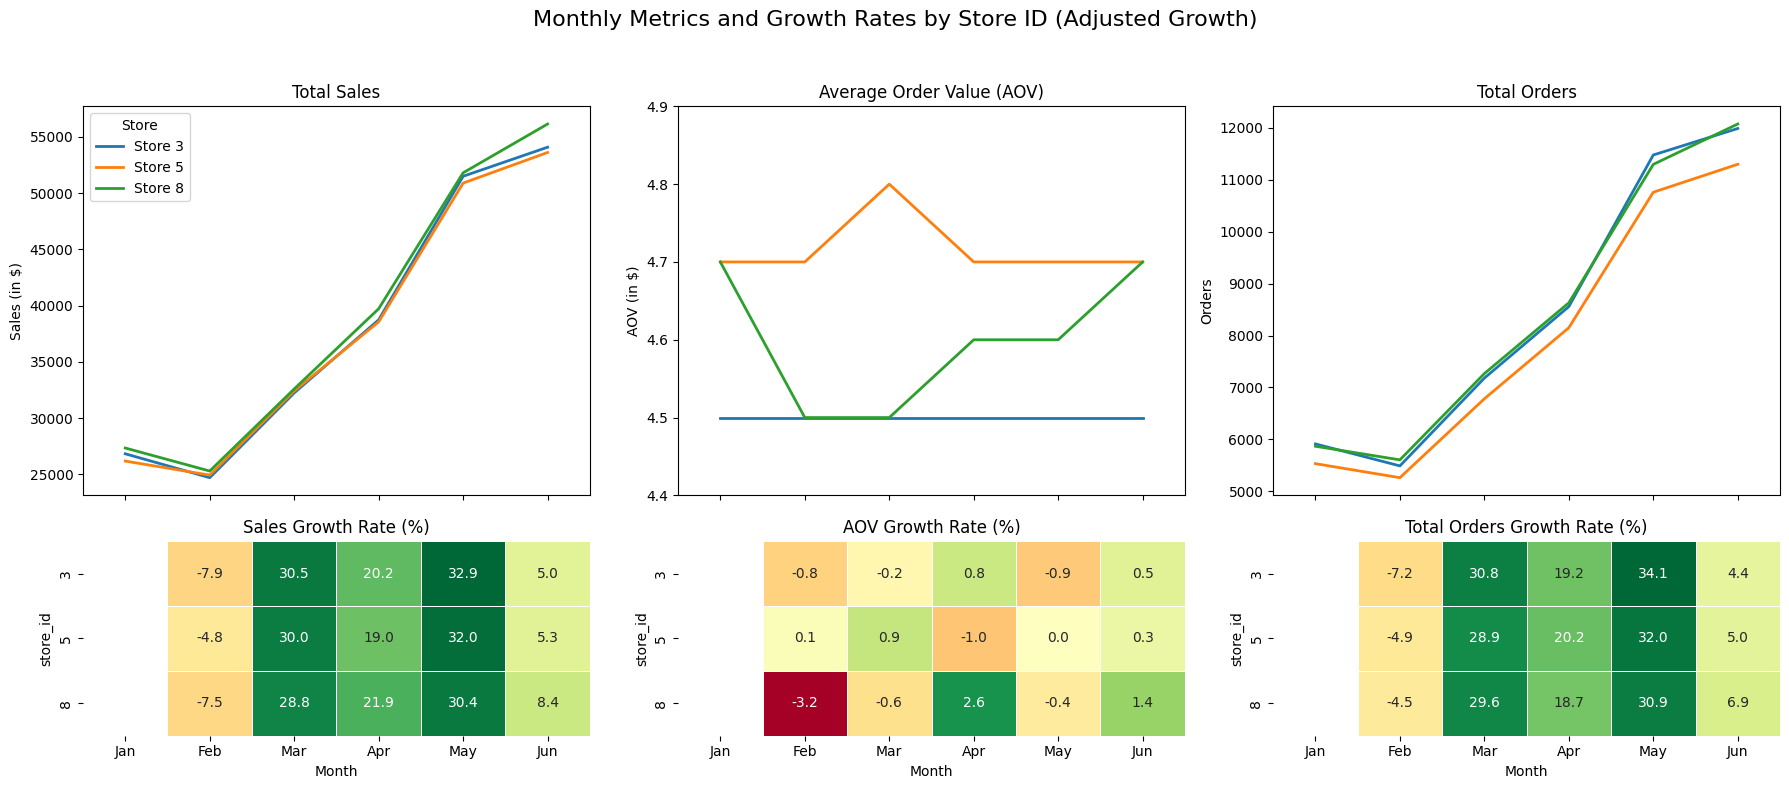

In [36]:
# Define the metrics, titles, and y_labels
metrics = ['total_sales', 'avg_aov', 'total_orders']
titles = ['Total Sales', 'Average Order Value (AOV)', 'Total Orders']
y_labels = ['Sales (in $)', 'AOV (in $)', 'Orders']

# Define growth metrics and titles
growth_metrics = ['sales_growth_rate', 'aov_growth_rate', 'total_orders_rate']
growth_titles = ['Sales Growth Rate (%)', 'AOV Growth Rate (%)', 'Total Orders Growth Rate (%)']


# Set up the figure with a 2x3 grid: 3 line charts and 3 heatmaps
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

# Define colors for each store_id
stores = monthly_summary['store_id'].unique()
colors = plt.cm.tab10(np.arange(len(stores)))


# Plot line charts for each metric
for i, (metric, title, y_label) in enumerate(zip(metrics, titles, y_labels)):
    for j, store in enumerate(stores):
        store_data = monthly_summary[monthly_summary['store_id'] == store]
        # Adjust the month values by subtracting 0.5 to shift the data half a column left
        adjusted_months = store_data['month'] - 0.5
        axes[0, i].plot(adjusted_months, store_data[metric], label=f'Store {store}', color=colors[j], linewidth=2)
    
    axes[0, i].set_title(title)
    axes[0, i].set_ylabel(y_label)
    axes[0, i].set_xticks(range(1, 7))
    axes[0, i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    axes[0, i].set_xlim(0.5, 6.5)  # Adjust x-axis limits to provide padding

    # Set y-axis limits for the AOV plot to ensure full range is shown
    if metric == 'avg_aov':
        axes[0, i].set_ylim(monthly_summary[metric].min() - 0.1, monthly_summary[metric].max() + 0.1)  # Adjust as needed

    if i == 0:
        axes[0, i].legend(title='Store', loc='upper left')



# Prepare and plot heatmaps for growth rates
for i, (growth_metric, growth_title) in enumerate(zip(growth_metrics, growth_titles)):
    # Ensure the months are sorted correctly
    growth_data = monthly_summary.pivot_table(index='store_id', columns='month', values=growth_metric)
    growth_data = growth_data.reindex(columns=range(1, 7))  # Ensure columns are in the correct month order
    sns.heatmap(growth_data, cmap='RdYlGn', ax=axes[1, i], cbar=False, annot=True, fmt=".1f", center=0, linewidths=0.5)
    axes[1, i].set_title(growth_title)
    axes[1, i].set_xticks(np.arange(0.5, 6))
    axes[1, i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
    axes[1, i].set_xlabel('Month')

# Final layout adjustments
plt.suptitle('Monthly Metrics and Growth Rates by Store ID (Adjusted Growth)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/monthly_growth_rates_plot_heatmap', dpi=300, bbox_inches = 1)

In [26]:
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,revenue,month,total_sales,day_of_week,hour
0,1,2023-01-01,1900-01-01 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6,1,6.0,6,7
1,2,2023-01-01,1900-01-01 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6,1,6.2,6,7
2,3,2023-01-01,1900-01-01 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,8,1,9.0,6,7
3,4,2023-01-01,1900-01-01 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2,1,2.0,6,7
4,5,2023-01-01,1900-01-01 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6,1,6.2,6,7


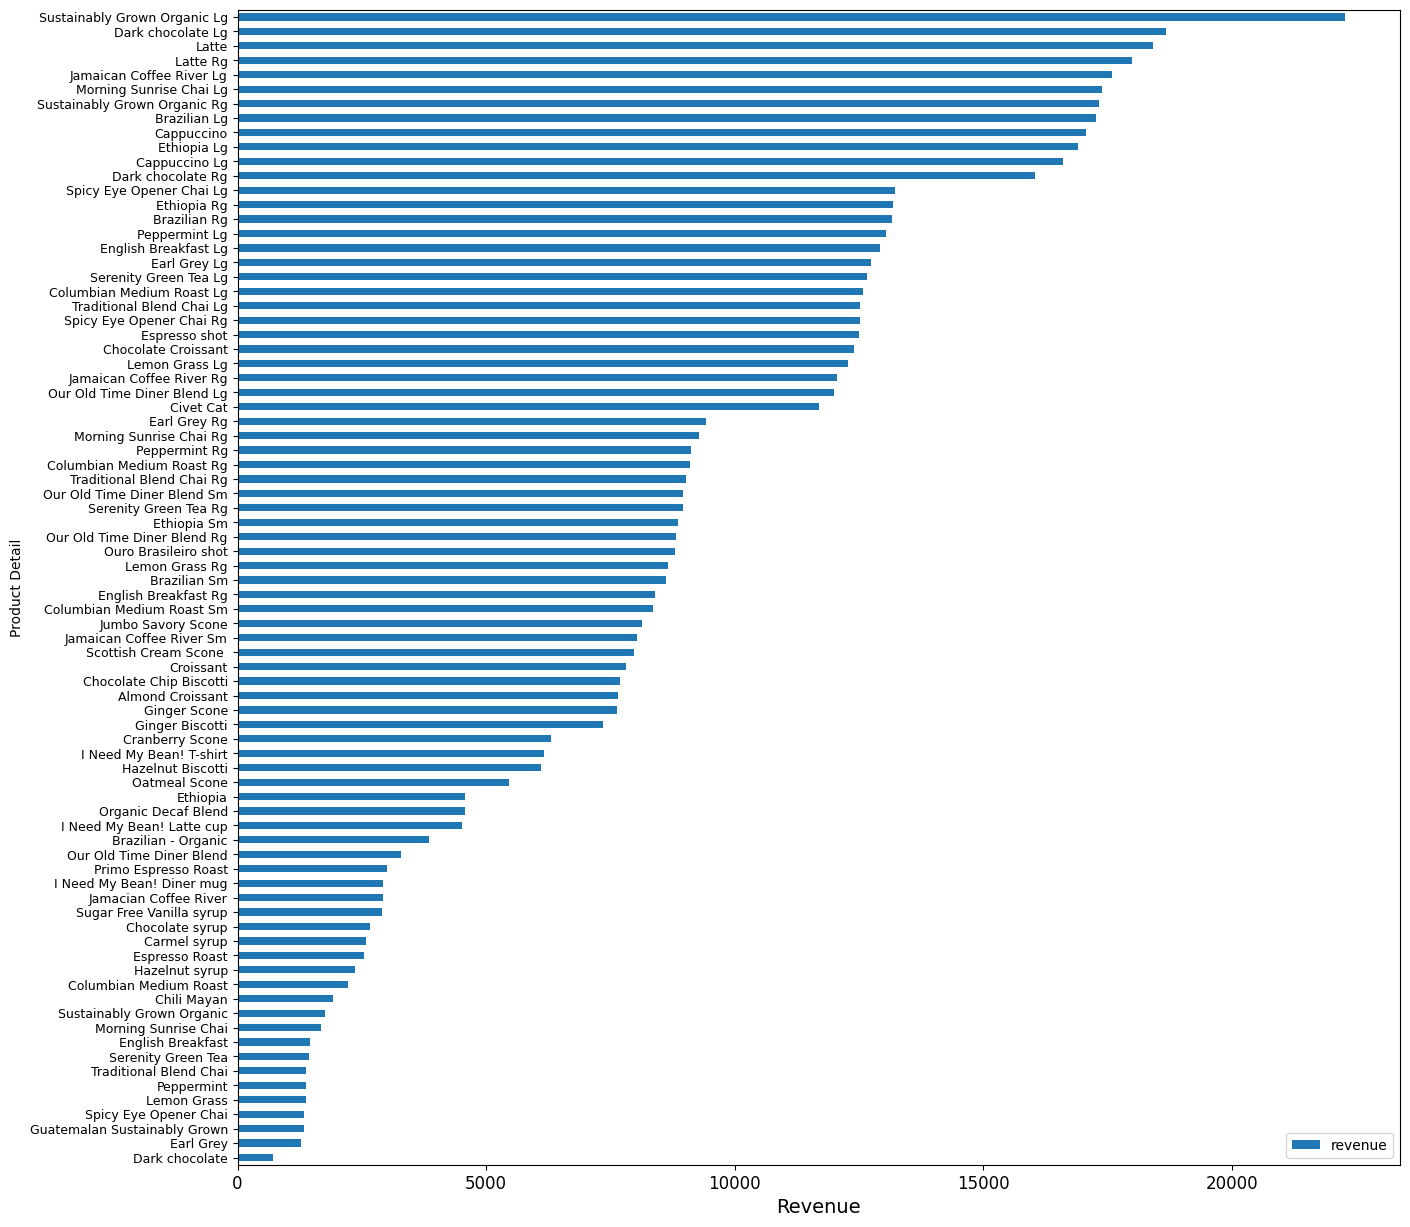

In [40]:
# Generate the plot to category sales by product
ax = (df
      .groupby("product_detail")
      .agg({"revenue": "sum"})
      .sort_values("revenue")
      .plot
      .barh(figsize=(15, 15)))

    

# Customize text label size
ax.set_xlabel('Revenue', fontsize=14)  # Change x-axis label size
ax.set_ylabel('Product Detail', fontsize=10)  # Change y-axis label size

# Customize the y-axis ticks
ax.tick_params(axis='y', labelsize=9)  # Change size of y-axis tick labels

# Customize the x-axis ticks
ax.tick_params(axis='x', labelsize=12)  # Change size of x-axis tick labels

plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/product_detail_revenue_barcharh', dpi=500, bbox_inches = 'tight')

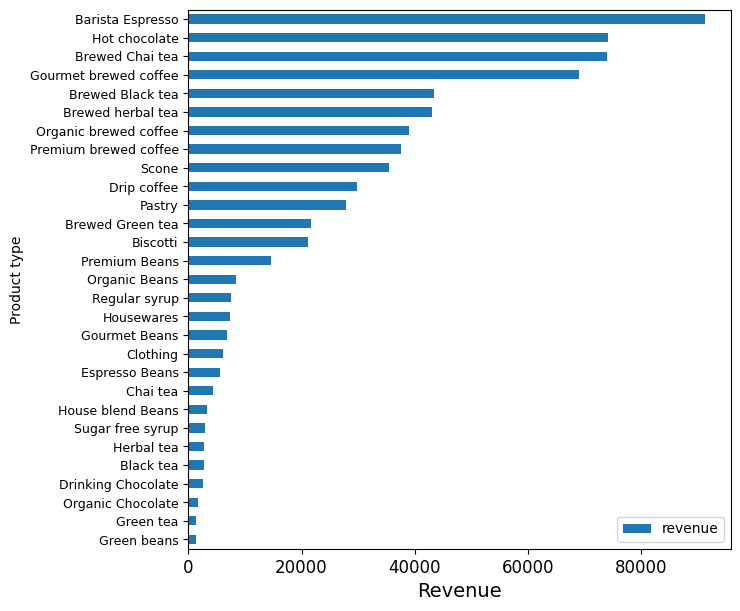

In [41]:
# Generate the plot
ax = (df
      .groupby("product_type")
      .agg({"revenue": "sum"})
      .sort_values("revenue")
      .plot
      .barh(figsize=(7, 7)))

    

# Customize text label size
ax.set_xlabel('Revenue', fontsize=14)  # Change x-axis label size
ax.set_ylabel('Product type', fontsize=10)  # Change y-axis label size

# Customize the y-axis ticks
ax.tick_params(axis='y', labelsize=9)  # Change size of y-axis tick labels

# Customize the x-axis ticks
ax.tick_params(axis='x', labelsize=12)  # Change size of x-axis tick labels

plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/product_type_revenue_barcharh', dpi=500, bbox_inches = 'tight')

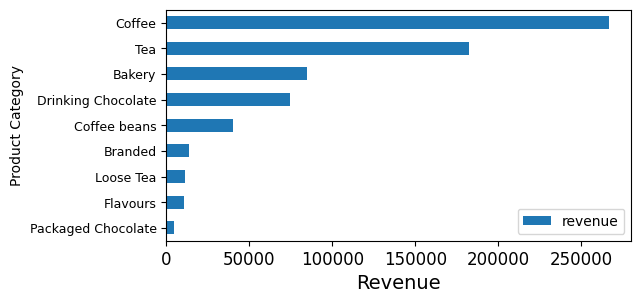

In [42]:
# Generate the plot
ax = (df
      .groupby("product_category")
      .agg({"revenue": "sum"})
      .sort_values("revenue")
      .plot
      .barh(figsize=(6,3)))

    

# Customize text label size
ax.set_xlabel('Revenue', fontsize=14)  # Change x-axis label size
ax.set_ylabel('Product Category', fontsize=10)  # Change y-axis label size

# Customize the y-axis ticks
ax.tick_params(axis='y', labelsize=9)  # Change size of y-axis tick labels

# Customize the x-axis ticks
ax.tick_params(axis='x', labelsize=12)  # Change size of x-axis tick labels

plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/product_category_revenue_barcharh', dpi=500, bbox_inches = 'tight')

In [30]:
# Add revenue, day of week and hour on df
df['total_sales'] = (df.transaction_qty * df.unit_price).round(2) 
df['day_of_week'] = df.transaction_date.dt.dayofweek
df['hour'] = df.transaction_time.dt.hour

df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,revenue,month,total_sales,day_of_week,hour
0,1,2023-01-01,1900-01-01 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6,1,6.0,6,7
1,2,2023-01-01,1900-01-01 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6,1,6.2,6,7
2,3,2023-01-01,1900-01-01 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,8,1,9.0,6,7
3,4,2023-01-01,1900-01-01 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2,1,2.0,6,7
4,5,2023-01-01,1900-01-01 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6,1,6.2,6,7


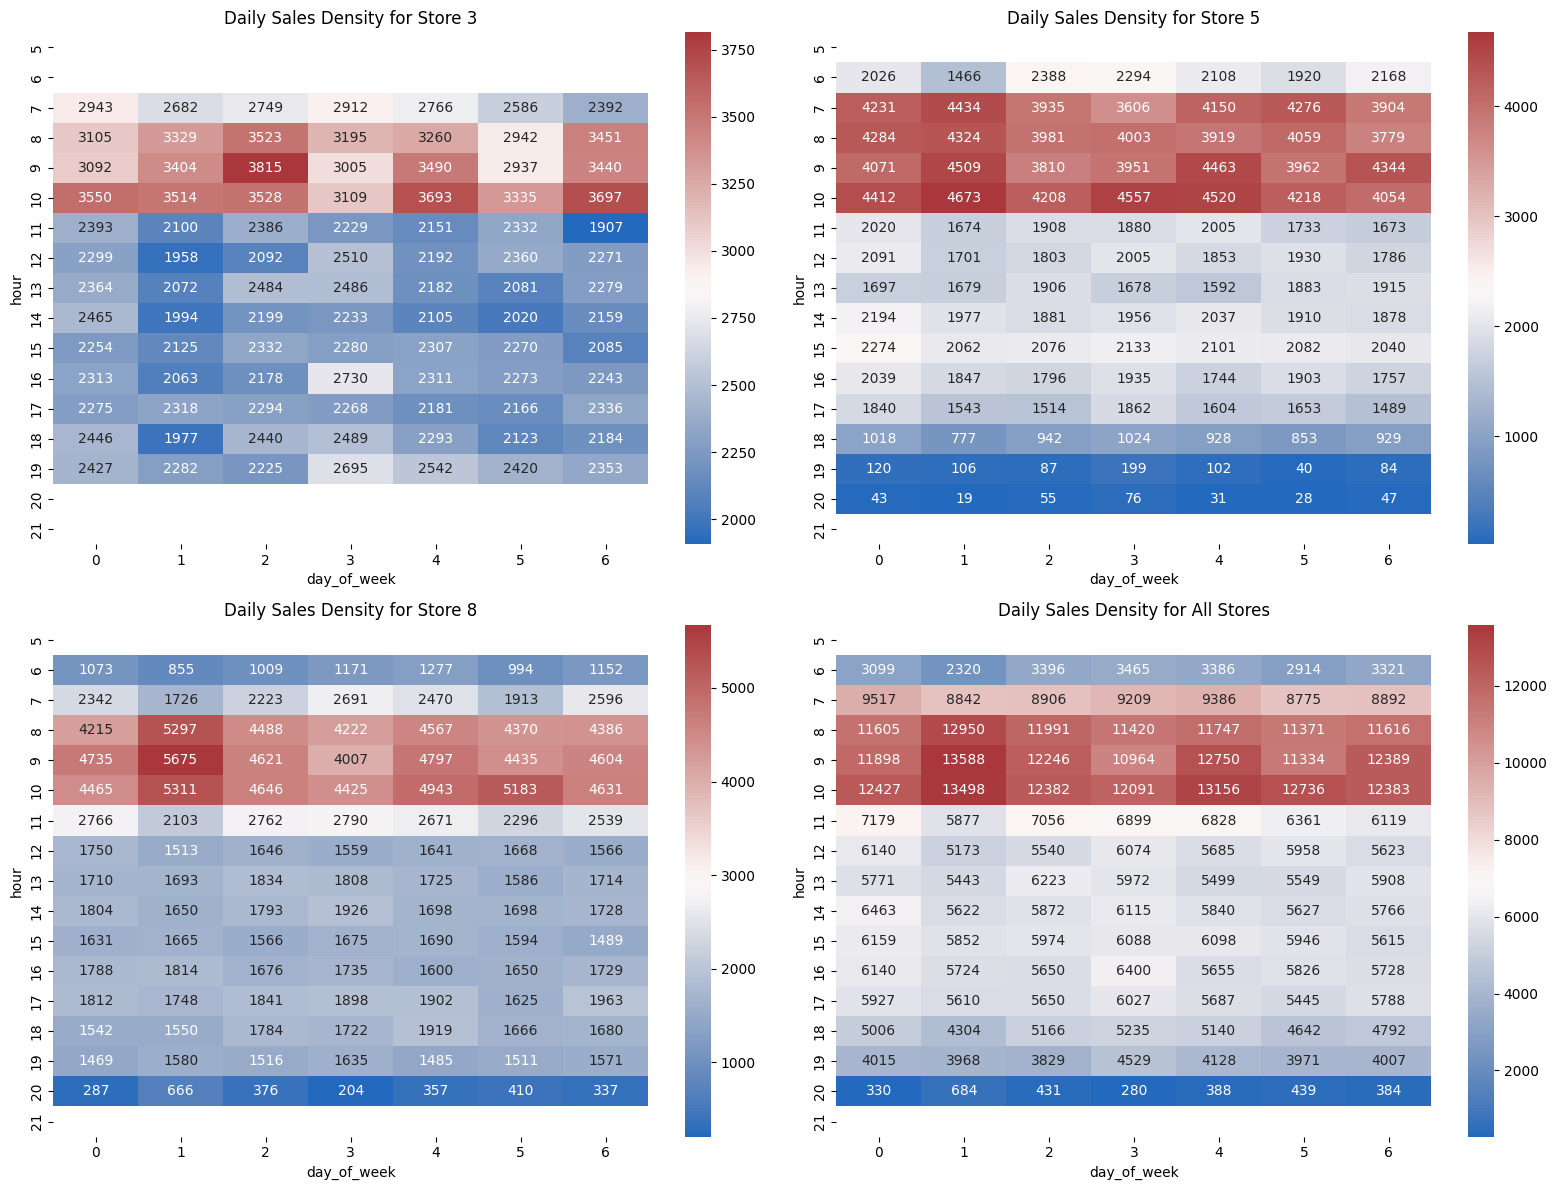

In [43]:
# Define a function to create the heatmap for a specific store
def create_store_heatmap(ax, store_id=None):
    if store_id:
        store_data = df[df['store_id'] == store_id]
        title = f'Daily Sales Density for Store {store_id}'
    else:
        store_data = df
        title = 'Daily Sales Density for All Stores'
    
    # Generate the pivot table and reindex to ensure all hours are included
    pivot_table = store_data.pivot_table(
        index='hour',
        columns='day_of_week',
        values='total_sales',
        aggfunc='sum'
    ).reindex(range(5, 22))

    # Create the heatmap
    sns.heatmap(
        pivot_table.round(),
        annot=True,
        fmt='g',
        cmap='vlag',
        ax=ax
    )

    # Add a title to the heatmap
    ax.set_title(title, fontsize=12)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create individual heatmaps for stores 3, 5, and 8, and one for all stores
create_store_heatmap(axes[0, 0], store_id=3)
create_store_heatmap(axes[0, 1], store_id=5)
create_store_heatmap(axes[1, 0], store_id=8)
create_store_heatmap(axes[1, 1])

# Adjust the layout to make sure everything fits nicely
plt.tight_layout()

# Display the plot
plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/daily_sales_density_heatmap', dpi=500, bbox_inches = 'tight')



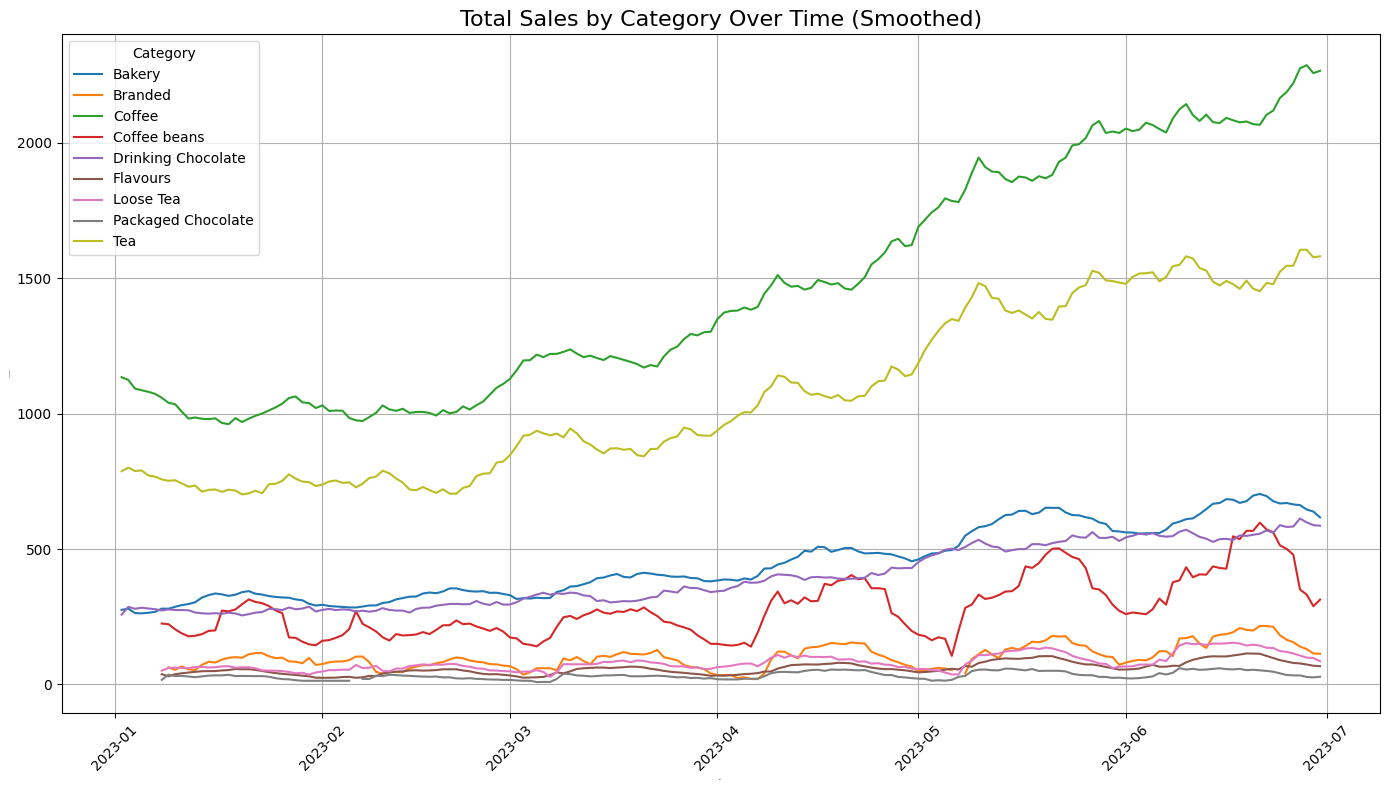

In [44]:
# Group by 'category' and 'transaction_date' to sum total sales
sales_by_category_day = df.groupby(['product_category', 'transaction_date'])['total_sales'].sum().reset_index()

# Pivot the data to have dates as columns
sales_pivot = sales_by_category_day.pivot(index='transaction_date', columns='product_category', values='total_sales')

# Apply rolling mean for smoothing
sales_pivot_smooth = sales_pivot.rolling(window=10, min_periods=2).mean()

# Plot the line chart
fig, ax = plt.subplots(figsize=(14, 8))

# Iterate over each category to plot its smoothed line
for category in sales_pivot_smooth.columns:
    ax.plot(sales_pivot_smooth.index, sales_pivot_smooth[category], linestyle='-', label=category)

# Customize the plot
ax.set_title('Total Sales by Category Over Time (Smoothed)', fontsize=16)
ax.set_xlabel('Date', fontsize=0)
ax.set_ylabel('Total Sales', fontsize=0)
ax.legend(title='Category', fontsize=10)
ax.grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.savefig('C:/Users/Pablo/Documents/Github/EspressoYourself_biannual_analysis/EspressoYourself-Biannual_Analysis/Visualizations_Files/daily_product_category_revenue_plotline', dpi=500, bbox_inches = 'tight')
